In [3]:
%matplotlib inline
import numpy as np
from IPython.core.debugger import set_trace
import time

# import _pickle as cPickle
# import os
# import gzip
# from IPython.core.debugger import set_trace
# import scipy.optimize
import matplotlib.pyplot as plt
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

# Second exercise: CNN
In this exercise you will implement a CNN

In [4]:
# load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# set_trace()
print("mnist {}".format(mnist))
# set_trace()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
mnist Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f027264b860>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f0264e4c320>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f0264e4cb38>)


In [5]:
def define_graph(filter_no = 16):

    # define input variable
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])


    
    # initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients
    # The generated values follow a normal distribution with specified mean and standard deviation, 
    # except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    # define small positive constant bias
    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    # Computes a 2-D convolution given 4-D input and filter tensors. returning 4D tensor of same type as x
    # ? means zero padding überall 2, oder ?
    # X has 4D data format [batch, height, width, color channels]
    # filter w has shape [filter_height, filter_width, in_channels, out_channels]  (no of filters, first colors...?)
    # strides = The stride of the sliding window for each dimension of input 
    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

# def define_graph(filter_no = 16):

    # first convolutional layer with 16 filters, one color
    # initialise weights and bias (slightly randomized)
    # 3 x 3, 1 input (only one color), 16 output channels
    W_conv1 = weight_variable([3, 3, 1, filter_no])
    b_conv1 = bias_variable([filter_no])

    # define tensor representing input layer: reshape flattened 748 Vector to 4d tensor 28 x 28 image matrices
    # and the final dimension corresponding to the number of color channels.
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # convolve, same size (padding, stride...), reduce size to 14x14 by maxpooling
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # define second layer convolving same size, 
    W_conv2 = weight_variable([3, 3, filter_no, filter_no])  # ??
    b_conv2 = bias_variable([filter_no])

    # convolve, same size (padding, stride...), reduce size to 7x7 by maxpooling
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # we add a fully-connected layer with 128 neurons to allow processing on the entire image.
    # We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, 
    # and apply a ReLU.
    W_fc1 = weight_variable([7 * 7 * filter_no, 128])
    b_fc1 = bias_variable([128])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*filter_no])   # shape is inferred as to fit to second argument
    #test1 = tf.shape(h_pool2_flat)
    #print("test1: {}".format(test1))
    #test2 = h_pool2_flat.get_shape()
    #print("test2: {}".format(test2))
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # implement dropout
    # keep_prob = tf.placeholder(tf.float32)
    # h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # final fully connected layer
    W_fc2 = weight_variable([128, 10])
    b_fc2 = bias_variable([10])

    # y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

    return (x, y_conv, y_)

def count_number_trainable_params():
    # Counts the number of trainable variables.
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    return tot_nb_params

def get_nb_params_shape(shape):
    # Computes the total number of params for a given shape.
    # Works for any number of shapes etc [D,F] or [W,H,C] computes D*F and W*H*C.
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params 

In [6]:
def execute_learning_rates(x, y_conv, y_):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
    # train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    epochs = 10
    learning_rates = np.array([0.1,0.01,0.001,0.0001])
    test_accuracies = np.zeros([learning_rates.shape[0],epochs])

    with tf.Session() as sess:

        for k, learning_rate in enumerate(learning_rates):
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            sess.run(tf.global_variables_initializer())
            for epoch in range(epochs):
                for i in range(100):
                    batch = mnist.train.next_batch(50)
                    if i % 50 == 0:
                        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
                        print("step {}, batch training accuracy {:.4f}".format(i, train_accuracy))
                    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

                test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                test_accuracies[k,epoch] = test_accuracy
                print("test accuracy epoch {}: {:.4f}".format(epoch, test_accuracy))
            print("learningrate {} finished\n".format(learning_rate))
    # print("test_accuracies {}".format(test_accuracies))
    return(learning_rates, test_accuracies)

def execute_filters(x, y_conv, y_):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
    # train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    epochs = 4
    learning_rate = 0.1
    # learning_rates = np.array([0.1,0.01,0.001,0.0001])
    # test_accuracies = np.zeros([learning_rates.shape[0],epochs])

    with tf.Session() as sess:
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for i in range(50):
                batch = mnist.train.next_batch(50)
                if i % 50 == 0:
                    train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
                    print("step {}, batch training accuracy {:.4f}".format(i, train_accuracy))
                train_step.run(feed_dict={x: batch[0], y_: batch[1]})

            test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            # test_accuracies[k,epoch] = test_accuracy
            print("test accuracy epoch {}: {:.4f}".format(epoch, test_accuracy))
    # print("test_accuracies {}".format(test_accuracies))

In [17]:
x, y_conv, y_ = define_graph(filter_no = 16)
learning_rates, test_accuracies = execute_learning_rates(x, y_conv, y_)

step 0, batch training accuracy 0.1000
step 50, batch training accuracy 0.6800
test accuracy epoch 0: 0.8102
step 0, batch training accuracy 0.7600
step 50, batch training accuracy 0.8600
test accuracy epoch 1: 0.9315
step 0, batch training accuracy 0.9400
step 50, batch training accuracy 0.9400
test accuracy epoch 2: 0.9359
step 0, batch training accuracy 0.9200
step 50, batch training accuracy 0.9600
test accuracy epoch 3: 0.9441
step 0, batch training accuracy 1.0000
step 50, batch training accuracy 0.9400
test accuracy epoch 4: 0.9516
step 0, batch training accuracy 1.0000
step 50, batch training accuracy 0.9800
test accuracy epoch 5: 0.9663
step 0, batch training accuracy 1.0000
step 50, batch training accuracy 0.9200
test accuracy epoch 6: 0.9618
step 0, batch training accuracy 0.9600
step 50, batch training accuracy 0.9400
test accuracy epoch 7: 0.9643
step 0, batch training accuracy 0.9800
step 50, batch training accuracy 0.9600
test accuracy epoch 8: 0.9732
step 0, batch train

In [1]:
plt.figure(figsize=(12, 8))
for k, learning_rate in enumerate(learning_rates):
    plt.plot(test_accuracies[k,:], label="learning rate: {}".format(learning_rate))
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

NameError: name 'plt' is not defined

In [12]:
# filters = (8,16,32,64,128,256)
filters = (4,8,12,16,24,32)
param_nos = np.zeros_like(filters)
runtimes = np.zeros_like(filters,dtype=float)
for i, filter in enumerate(filters):
    t0 = time.time()
    tf.reset_default_graph()   # without reset, new nodes are added to previous ones
    x, y_conv, y_ = define_graph(filter_no = filter)
    execute_filters(x, y_conv, y_)    # train and test with updated graph
    runtimes[i] = time.time() - t0
    param_nos[i] = count_number_trainable_params()
    print("tests with {} filters finished \n".format(filter))

print("runtimes: {}".format(runtimes))
print("param_nos: {}".format(param_nos))

step 0, batch training accuracy 0.0800
test accuracy epoch 0: 0.5127
step 0, batch training accuracy 0.5200
test accuracy epoch 1: 0.8305
step 0, batch training accuracy 0.8200
test accuracy epoch 2: 0.8580
step 0, batch training accuracy 0.8600
test accuracy epoch 3: 0.9168
tests with 4 filters finished 

step 0, batch training accuracy 0.1000
test accuracy epoch 0: 0.6590
step 0, batch training accuracy 0.6400
test accuracy epoch 1: 0.8027
step 0, batch training accuracy 0.7800
test accuracy epoch 2: 0.8417
step 0, batch training accuracy 0.9000
test accuracy epoch 3: 0.8974
tests with 8 filters finished 

step 0, batch training accuracy 0.1000
test accuracy epoch 0: 0.7834
step 0, batch training accuracy 0.7200
test accuracy epoch 1: 0.8861
step 0, batch training accuracy 0.9400
test accuracy epoch 2: 0.9225
step 0, batch training accuracy 0.9400
test accuracy epoch 3: 0.9097
tests with 12 filters finished 

step 0, batch training accuracy 0.1000
test accuracy epoch 0: 0.6537
step 0

Text(0,0.5,'runtime / seconds')

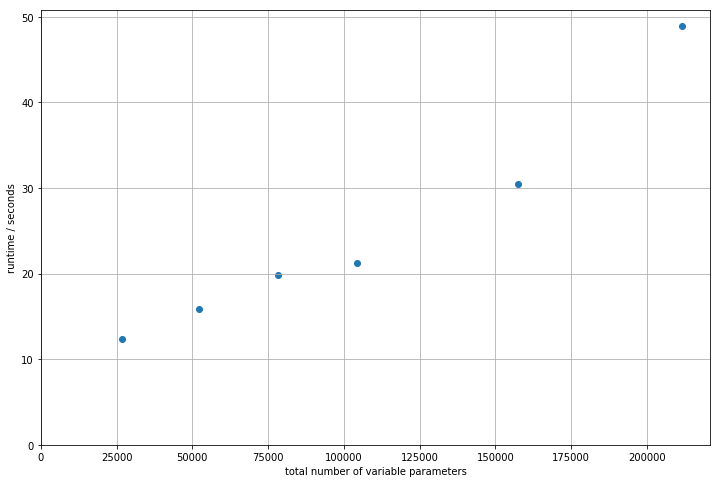

In [13]:
plt.figure(figsize=(12, 8))
# plt.xscale('log')
# plt.yscale('log')
plt.scatter(param_nos, runtimes)

# for k, learning_rate in enumerate(param_nos):
#     plt.plot(test_accuracies[k,:], label="learning rate: {}".format(learning_rate))
plt.grid(True)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("total number of variable parameters")
plt.ylabel("runtime / seconds")